In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.datacollection import DataCollector

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import clear_output

arr = np.array

In [36]:
%matplotlib inline

def compute_gini(model):
    agent_budgets = [a.budget for a in model.schedule.agents]
    x = sorted(agent_budgets)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.budget = 100
        self.quality = np.random.rand()
        self.wins = 0

    def submit_bid(self):
        self.bid = round(np.random.gamma(10), 3)
        if self.bid>self.budget:
            self.bid = self.budget
        return self.bid
        
    def step(self):
        if self.budget == 0:
            return
        if self.unique_id == mod.winner:
            self.budget -= self.bid
            self.wins += 1
    
    def advance(self):
#         print('advancing')
        pass
        
class MoneyModel(Model):
    def __init__(self, N, verbose=False):
        self.verbose = verbose
        self.num_agents = N
        self.schedule = SimultaneousActivation(self)
        self.round_cnt = 0
        self.revenue = 0
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
        self.datacollector = DataCollector(model_reporters={'Gini':compute_gini, 'Revenue': 'revenue', 'Max_bid':'max_bid'},
                                            agent_reporters={'Budget':'budget'})
            
    def step(self):
        
        scores = arr([a.submit_bid()*a.quality for a in self.schedule.agents]).round(3)
        bids = arr([a.submit_bid() for a in self.schedule.agents]).round(3)
        self.winner = scores.argmax()
        self.max_bid = bids.max()
        self.revenue += self.max_bid
        
        self.round_cnt += 1 
        self.datacollector.collect(self)
        self.schedule.step()
        
        if self.verbose:
            clear_output()
            print('ROUND:', self.round_cnt, '\n', '='*20)
            print('scores:', scores)
            print('bids:', bids)
            print('winner:', self.winner)
            print('budgets', [round(a.budget,3) for a in self.schedule.agents])
            print('win counter: ', [a.wins for a in self.schedule.agents])

# np.random.seed(1)
num_agents = 10
num_steps = 80

mod = MoneyModel(num_agents, verbose=True)
for i in range(num_steps):
    mod.step()

ROUND: 80 
scores: [3.662 0.    5.591 0.    0.288 2.619 0.    2.21  2.246 0.779]
bids: [ 6.562  0.     5.855  0.     0.424 11.969  0.     2.384 13.254  1.874]
winner: 2
budgets [25.424, 0.0, 50.757, 0.0, 0.424, 76.377, 0.0, 2.384, 100, 1.874]
win counter:  [7, 10, 7, 12, 11, 3, 12, 9, 0, 9]


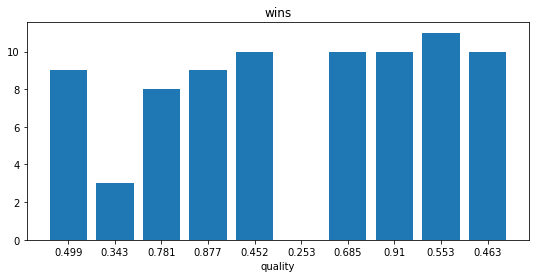

In [28]:
fig, ax = plt.subplots(figsize=(9,4))

ax.bar(range(num_agents), [a.wins for a in mod.schedule.agents])
ax.set_xticks(range(num_agents))
ax.set_xticklabels([round(a.quality,3) for a in mod.schedule.agents])
ax.set_title('wins')
ax.set_xlabel('quality')
plt.show()

## Model variables

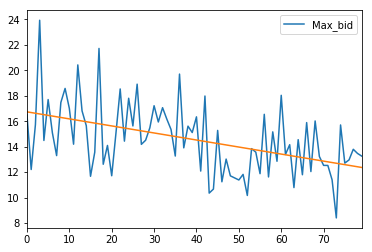

In [37]:
df = mod.datacollector.get_model_vars_dataframe()
b,a = np.polyfit(x=df.index, y=df.Max_bid, deg=1)

df.Max_bid.plot()
plt.plot(df.index, a+df.index*b)
plt.legend()
plt.show()

## Agent variables

In [39]:
df = mod.datacollector.get_agent_vars_dataframe()
df = df.reset_index().pivot(index='Step', columns='AgentID', values='Budget')
qualities = arr([round(a.quality,3) for a in mod.schedule.agents])
# df.head(20)
df.loc[:3]

AgentID,0,1,2,3,4,5,6,7,8,9
Step,,,,,,,,,,
0,100.0,100.000,100.0,100.0,100.0,100.0,100.000,100.0,100.0,100.0
1,100.0,88.010,100.0,100.0,100.0,100.0,100.000,100.0,100.0,100.0
2,100.0,76.793,100.0,100.0,100.0,100.0,100.000,100.0,100.0,100.0
3,100.0,76.793,100.0,100.0,100.0,100.0,91.196,100.0,100.0,100.0


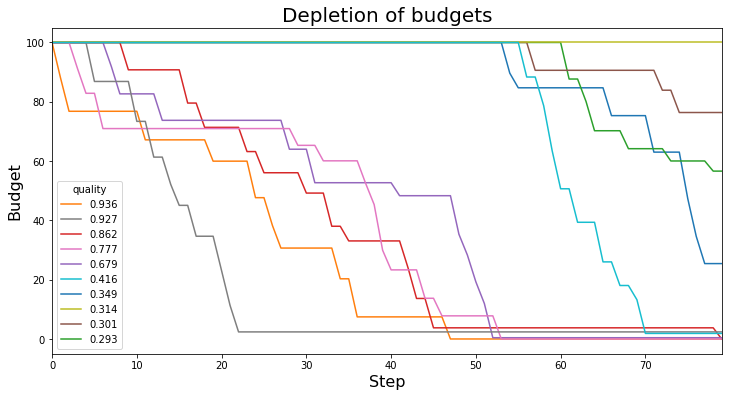

In [40]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,6))
df.plot(ax=ax)
ax.set_xlabel('Step', fontsize=16)
ax.set_ylabel('Budget', fontsize=16)

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
# key=lambda t: t[0]
labels, handles = zip(*sorted(zip(qualities, handles), reverse=True))
ax.legend(handles, labels, title='quality', loc=3)

# ax.legend(labels=qualities)
# ax.set_xticks(df.index)
ax.set_title("Depletion of budgets", fontsize=20)
plt.show()

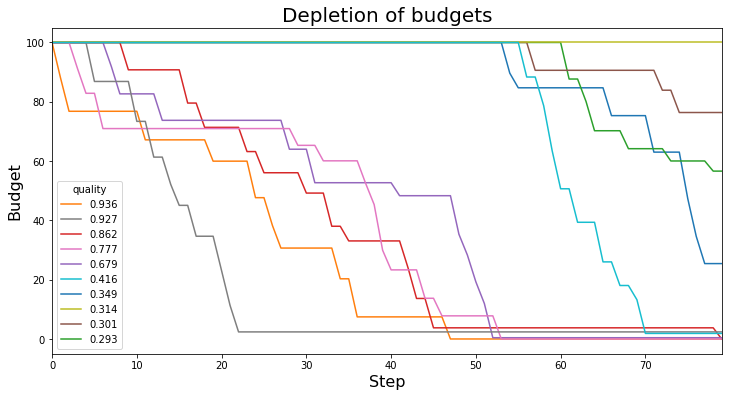

In [41]:
%matplotlib qt
fig, ax = plt.subplots(figsize=(12,6))

for i in range(3, df.index.shape[0]):
    ax.clear()
    df.loc[:i].plot(ax=ax)
    
    ax.set_xlabel('Step', fontsize=16)
    ax.set_ylabel('Budget', fontsize=16)
    ax.set_title("Depletion of budgets", fontsize=20)

    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(qualities, handles), reverse=True))
    ax.legend(handles, labels, title='quality', loc=3)
    plt.pause(0.1)
    
plt.show()